# HW 4 - Variational Autoencoders and Diffusion Models

In this homework, you will implement a vanilla VAE for image generation on the MNIST dataset. Then you will implement an unconditional diffusion model and a conditional diffusion model for MNIST, both based on DDPM (Denoising Diffusion Probabilistic Models). Write all your code between # todo: student code here and # end student code, and do not modify any code outside these blocks.

In [1]:
%pip install -q otter-grader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.8/118.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 MB 47.7 MB/s eta 0:00:00


In [2]:
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    ! git clone https://github.com/tianyyiii/6740-hw4.git tests
    import otter
    grader = otter.Notebook()
else:
    print("Not running in Colab")

Cloning into 'tests'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 18 (delta 9), reused 18 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 29.03 KiB | 29.03 MiB/s, done.
Resolving deltas: 100% (9/9), done.


## 1. Variational Autoencoders (20 pts)

You are asked to complete the missing parts of the VAE implementation by filling in the following functions:

1. **`reparameterize(mu, log_var)`**  
Implement the reparameterization trick. Given the encoder’s predicted mean `mu` and log-variance `log_var`, sample a latent vector `z` in a differentiable way.

2. **`forward(x)`**  
Implement the VAE forward pass. Encode the input `x` to get `mu` and `log_var`, sample a latent vector using `reparameterize`, and decode it to produce the reconstruction.

3. **`reconst_loss(x_reconst, x)`**  
Implement the reconstruction loss term (use binary cross-entropy).

4. **`kl_div(log_var, mu)`**  
Implement the KL divergence term in VAE training loss.

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# random seeds for reproducability
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create a directory if not exists
sample_dir = 'vae_samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 5
num_epochs = 15
batch_size = 128
learning_rate = 1e-3

In [4]:
# MNIST dataset
dataset = torchvision.datasets.MNIST(root='./data',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.95MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


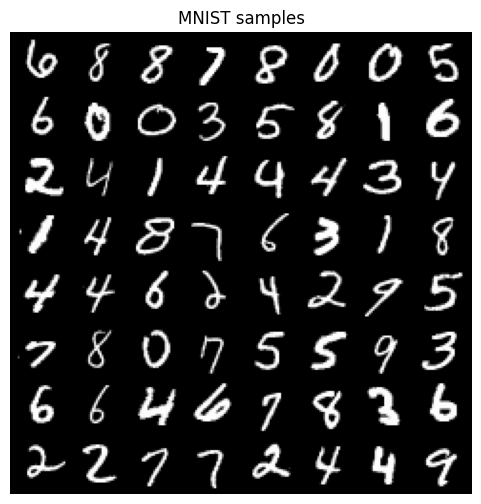

In [5]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

images, labels = next(iter(data_loader))
grid = make_grid(images[:64], nrow=8, padding=2)

plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).numpy().squeeze(), cmap="gray")
plt.axis("off")
plt.title("MNIST samples")
plt.show()

In [6]:
# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

    def reparameterize(self, mu, log_var):
        """Sample a latent vector using the reparameterization trick.
        Input:
            mu: torch.Tensor of shape (batch_size, z_dim), mean of q(z|x)
            log_var: torch.Tensor of shape (batch_size, z_dim), log-variance (log(sigma^2)) of q(z|x)
        Output:
            z: torch.Tensor of shape (batch_size, z_dim), a differentiable latent vector sample
        """
        # todo: student code here
        std = torch.exp(0.5 * log_var)       # standard deviation
        eps = torch.randn_like(std)          # sample epsilon ~ N(0,1)
        z = mu + std * eps
        # end student code
        return z

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))

    def forward(self, x):
        """Perform a full VAE forward pass.
        Input:
            x: torch.Tensor of shape (batch_size, image_size), input data
        Output:
            x_reconst: torch.Tensor of shape (batch_size, image_size), reconstructed input
            mu: torch.Tensor of shape (batch_size, z_dim), latent mean from the encoder
            log_var: torch.Tensor of shape (batch_size, z_dim), latent log-variance from the encoder
        """
        # todo: student code here
        mu, log_var = self.encode(x)         # encode to latent parameters
        z = self.reparameterize(mu, log_var) # sample latent vector
        x_reconst = self.decode(z)
        # end student code
        return x_reconst, mu, log_var

In [7]:
grader.check("q1")

q1 results: All test cases passed!

In [8]:
def reconst_loss(x_reconst, x):
    """Compute reconstruction loss for a VAE using binary cross-entropy loss.
    Input:
        x_reconst: torch.Tensor of shape (batch_size, image_size), reconstructed results
        x: torch.Tensor of shape of shape (batch_size, image_size), original inputs
    Output:
        loss: torch.Tensor scalar, reconstruction loss
    """
    # todo: student code here
    loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
    return loss
    # end student code

def kl_div(log_var, mu):
    """Compute the KL divergence loss.
    Input:
        log_var: torch.Tensor of shape (batch_size, z_dim), log-variance (log(sigma^2))
        mu: torch.Tensor of shape (batch_size, z_dim), mean
    Output:
        loss: torch.Tensor scalar, KL divergence loss
    """
    # todo: student code here
    kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return kl
    # end student code

In [9]:
grader.check("q2")

q2 results: All test cases passed!

In [10]:
model = VAE(z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)

        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper
        re_loss = reconst_loss(x_reconst, x)
        kl_loss = kl_div(log_var, mu)

        # Backprop and optimize
        loss = re_loss + kl_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), re_loss.item(), kl_loss.item()))

    with torch.no_grad():
        # Save the sampled images
        z = torch.randn(64, z_dim).to(device)
        out_sampled = model.decode(z).view(-1, 1, 28, 28)
        save_image(out_sampled, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # Save the reconstructed images
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

Epoch[1/15], Step [10/469], Reconst Loss: 36603.0781, KL Div: 1577.6876
Epoch[1/15], Step [20/469], Reconst Loss: 29199.1133, KL Div: 1393.1633
Epoch[1/15], Step [30/469], Reconst Loss: 28147.2422, KL Div: 959.2332
Epoch[1/15], Step [40/469], Reconst Loss: 26616.3750, KL Div: 905.7479
Epoch[1/15], Step [50/469], Reconst Loss: 27771.8711, KL Div: 769.3005
Epoch[1/15], Step [60/469], Reconst Loss: 26642.1172, KL Div: 715.7336
Epoch[1/15], Step [70/469], Reconst Loss: 24992.7129, KL Div: 950.5839
Epoch[1/15], Step [80/469], Reconst Loss: 23227.7148, KL Div: 948.5833
Epoch[1/15], Step [90/469], Reconst Loss: 22845.3301, KL Div: 1154.4148
Epoch[1/15], Step [100/469], Reconst Loss: 22042.8535, KL Div: 1148.0931
Epoch[1/15], Step [110/469], Reconst Loss: 21177.6641, KL Div: 1214.1449
Epoch[1/15], Step [120/469], Reconst Loss: 21044.4043, KL Div: 1281.7104
Epoch[1/15], Step [130/469], Reconst Loss: 20353.9492, KL Div: 1421.8933
Epoch[1/15], Step [140/469], Reconst Loss: 20123.7578, KL Div: 130

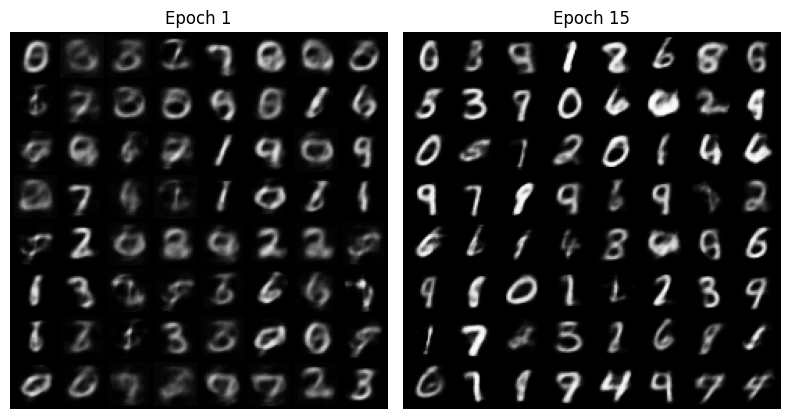

In [11]:
# Visualize sampled images from the first epoch and the last epoch
import matplotlib.pyplot as plt
from PIL import Image

first, last = 1, num_epochs
paths = [os.path.join(sample_dir, f"sampled-{first}.png"),
         os.path.join(sample_dir, f"sampled-{last}.png")]

fig, axes = plt.subplots(1, 2, figsize=(8, 8))
for ax, p, t in zip(axes, paths, [f"Epoch {first}", f"Epoch {last}"]):
    ax.imshow(Image.open(p), cmap='gray')
    ax.set_title(t)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [12]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

HF_MODEL_ID = "farleyknight/mnist-digit-classification-2022-09-04"

proc = AutoImageProcessor.from_pretrained(HF_MODEL_ID)
clf  = AutoModelForImageClassification.from_pretrained(HF_MODEL_ID).to(device).eval()

@torch.no_grad()
def recognized_ratio(imgs, tau=0.9):
    B = imgs.size(0)
    imgs3 = imgs.repeat(1,3,1,1)
    inputs = proc(images=imgs3, do_rescale=False, return_tensors="pt").to(device)
    logits = clf(**inputs).logits
    probs  = logits.softmax(-1)
    return (probs.max(dim=1).values >= tau).float().mean().item()

print(f"Recognized samples: {recognized_ratio(out_sampled, tau=0.9):.3f}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/985 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

Recognized samples: 0.562


The generated image quality will be manually graded by the TA. The grading guidelines include: the images should be recognizable as digits, they should cover different numbers from 0–9, and there should be no mode collapse within each class. You can refer to example generated samples here: https://drive.google.com/drive/folders/1EO_Gd_2bMaJDvlCMaX9vhSBzqOlj-nTn?usp=sharing.

The recognition ratio above is computed using a pretrained MNIST digit recognizer and it should be greater than 0.25 for VAE. Note that the final grading will be based on the manual grading according to the previously mentioned guidelines and the recognition ratio is only a reference metric.

## 2. Unconditional DDPM (15 pts)

In this question, you will complete an unconditional generation version of the DDPM implementation by filling in the following functions:

1. **`ddpm_schedules(beta1, beta2, T)`**  
Implement the diffusion noise schedule. Given the start/end noise levels (`beta1`, `beta2`) and the total number of timesteps `T`, compute and return all time-dependent coefficients (e.g. \(\alpha_t\), \(\bar{\alpha}_t\), etc.) that are used during training and sampling.

2. **`DDPM.forward(x)`**  
Implement the DDPM training step. For a batch of clean images `x`, sample a random timestep, and return the DDPM training loss.

3. **`DDPM.sample(n_sample, size, device)`**  
Implement the DDPM sampling procedure. Starting from pure Gaussian noise, iteratively apply the learned denoising model in reverse time (from \(T \rightarrow 1\)) to generate new images. Return the final generated samples and the stored intermediate samples for visualization.


In [13]:
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [14]:
class Unet(nn.Module):
    def __init__(self, in_channels, n_feat = 256):
        super(Unet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7),
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, t):
        # x is (noisy) image, t is timestep
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        # embed time step
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(up1+ temb1, down2)
        up3 = self.up2(up2+ temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

In [15]:
def ddpm_schedules(beta1, beta2, T):
    """Precompute schedules for DDPM sampling, training process.
    Input:
        beta1: float, starting value of the beta schedule
        beta2: float, ending value of the beta schedule
        T: int, number of diffusion steps
    Output:
        dict of torch.Tensors with shape (T+1,):
    Notes:
        - In every returned tensor, the first element (index 0) is only a placeholder, it will not be used by downstream code or tested.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = torch.linspace(beta1, beta2, T, dtype=torch.float32)
    beta_t = torch.cat([torch.zeros(1, dtype=torch.float32), beta_t], dim=0)
    sqrt_beta_t = torch.sqrt(beta_t)

    # todo: student code here
    # α_t = 1 − β_t
    alpha_t = 1.0 - beta_t

    # 1/sqrt(α_t)
    oneover_sqrta = 1.0 / torch.sqrt(alpha_t)

    # cumulative α̅_t = ∏_{i=1}^t α_i , with α̅_0 = 1
    alphabar_t = torch.cumprod(alpha_t, dim=0)

    # √(α̅_t)
    sqrtab = torch.sqrt(alphabar_t)

    # √(1 − α̅_t)
    sqrtmab = torch.sqrt(1.0 - alphabar_t)

    # (1 − α_t) / √(1 − α̅_t)
    # careful: division-by-zero is avoided because index 0 is unused
    ma_over_sqrtmab = (1.0 - alpha_t) / sqrtmab

    # end student code

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "ma_over_sqrtmab": ma_over_sqrtmab,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

In [16]:
grader.check("q3")

q3 results: All test cases passed!

In [24]:
class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device):
        super().__init__()
        self.nn_model = nn_model.to(device)

        # load schedule into buffers
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.loss_mse = nn.MSELoss()

    ###############################################################
    #                           FORWARD                           #
    ###############################################################
    def forward(self, x):
        B = x.shape[0]

        # sample random timestep
        i = torch.randint(1, self.n_T + 1, (B,), device=self.device)

        noise = torch.randn_like(x)

        sqrtab = self.sqrtab[i].reshape(B, 1, 1, 1)
        sqrtmab = self.sqrtmab[i].reshape(B, 1, 1, 1)

        # forward diffusion: x_i
        x_i = sqrtab * x + sqrtmab * noise

        # normalized timestep
        i_norm = i / self.n_T

        # predict noise
        noise_pred = self.nn_model(x_i, i_norm)

        # MSE loss
        loss = self.loss_mse(noise_pred, noise)
        return loss

    ###############################################################
    #                           SAMPLE                            #
    ###############################################################
    def sample(self, n_sample, size, device):

        # x_T ~ N(0, 1)
        x_i = torch.randn(n_sample, *size, device=device)
        x_i_store = []

        for i in range(self.n_T, 0, -1):       # << KEEP i (NOT t)
            i_batch = torch.full((n_sample,), i, device=device)

            # model predicts noise
            eps_theta = self.nn_model(x_i, i_batch / self.n_T)

            # coefficients
            a_t = self.alpha_t[i]
            one_over_sqrt_a = self.oneover_sqrta[i]
            ma_over_sqrtmab = self.ma_over_sqrtmab[i]

            # estimate x0
            x0_est = one_over_sqrt_a * (x_i - ma_over_sqrtmab * eps_theta)

            if i > 1:
                noise = torch.randn_like(x_i)
                x_i = x0_est + self.sqrt_beta_t[i] * noise
            else:
                x_i = x0_est

            # store snapshots for visualization
            if i % 20 == 0 or i == self.n_T or i < 8:
                x_i_store.append(x_i.detach().cpu().numpy())

        return x_i, np.array(x_i_store)


In [25]:
grader.check("q4")

q4 results: All test cases passed!

In [26]:
n_epoch = 20
batch_size = 256
n_T = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_classes = 10
n_feat = 128
lrate = 1e-4
os.makedirs('./ddpm_unconditional/', exist_ok=True)
save_dir = './ddpm_unconditional/'

# random seeds for reproducability
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

ddpm = DDPM(nn_model=Unet(in_channels=1, n_feat=n_feat), betas=(1e-4, 0.02), n_T=n_T, device=device)
ddpm.to(device)

tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1

dataset = MNIST("./data", train=True, download=True, transform=tf)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=5)
optim = torch.optim.Adam(ddpm.parameters(), lr=lrate)

for ep in range(n_epoch):
    print(f'epoch {ep}')
    ddpm.train()

    # linear lrate decay
    optim.param_groups[0]['lr'] = lrate * (1 - ep / n_epoch)

    pbar = tqdm(dataloader)
    for x, _ in pbar:
        optim.zero_grad()
        x = x.to(device)
        loss = ddpm(x)
        loss.backward()
        pbar.set_description(f"loss: {loss.item():.4f}")
        optim.step()

    ddpm.eval()
    with torch.no_grad():
        n_sample = 4 * n_classes
        x_gen, x_gen_store = ddpm.sample(n_sample, (1, 28, 28), device)
        grid = make_grid(x_gen, nrow=10)
        save_image(grid, save_dir + f"image_ep{ep}.png")

epoch 0


loss: 0.0516: 100%|██████████| 235/235 [00:54<00:00,  4.29it/s]


epoch 1


loss: 0.0502: 100%|██████████| 235/235 [00:53<00:00,  4.38it/s]


epoch 2


loss: 0.0283: 100%|██████████| 235/235 [00:53<00:00,  4.38it/s]


epoch 3


loss: 0.0284: 100%|██████████| 235/235 [00:53<00:00,  4.37it/s]


epoch 4


loss: 0.0311: 100%|██████████| 235/235 [00:53<00:00,  4.37it/s]


epoch 5


loss: 0.0360: 100%|██████████| 235/235 [00:53<00:00,  4.37it/s]


epoch 6


loss: 0.0329: 100%|██████████| 235/235 [00:53<00:00,  4.37it/s]


epoch 7


loss: 0.0335: 100%|██████████| 235/235 [00:53<00:00,  4.37it/s]


epoch 8


loss: 0.0341: 100%|██████████| 235/235 [00:53<00:00,  4.37it/s]


epoch 9


loss: 0.0268: 100%|██████████| 235/235 [00:53<00:00,  4.38it/s]


epoch 10


loss: 0.0266: 100%|██████████| 235/235 [00:53<00:00,  4.38it/s]


epoch 11


loss: 0.0345: 100%|██████████| 235/235 [00:53<00:00,  4.38it/s]


epoch 12


loss: 0.0291: 100%|██████████| 235/235 [00:53<00:00,  4.38it/s]


epoch 13


loss: 0.0242: 100%|██████████| 235/235 [00:53<00:00,  4.38it/s]


epoch 14


loss: 0.0321: 100%|██████████| 235/235 [00:53<00:00,  4.38it/s]


epoch 15


loss: 0.0285: 100%|██████████| 235/235 [00:53<00:00,  4.38it/s]


epoch 16


loss: 0.0292: 100%|██████████| 235/235 [00:53<00:00,  4.38it/s]


epoch 17


loss: 0.0346: 100%|██████████| 235/235 [00:53<00:00,  4.37it/s]


epoch 18


loss: 0.0249: 100%|██████████| 235/235 [00:53<00:00,  4.37it/s]


epoch 19


loss: 0.0273: 100%|██████████| 235/235 [00:53<00:00,  4.37it/s]


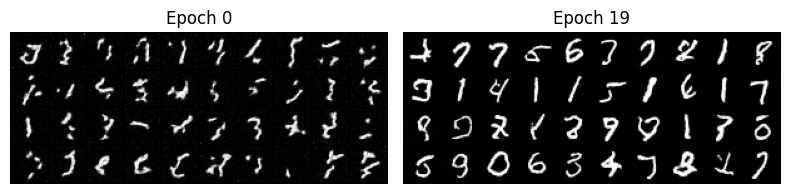

In [27]:
# visualize sampled images from the first epoch and the last epoch
import matplotlib.pyplot as plt
from PIL import Image

first, last = 0, 19
paths = [os.path.join("ddpm_unconditional", f"image_ep{first}.png"),
         os.path.join("ddpm_unconditional", f"image_ep{last}.png")]

fig, axes = plt.subplots(1, 2, figsize=(8, 8))
for ax, p, t in zip(axes, paths, [f"Epoch {first}", f"Epoch {last}"]):
    ax.imshow(Image.open(p), cmap='gray')
    ax.set_title(t)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [28]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

HF_MODEL_ID = "farleyknight/mnist-digit-classification-2022-09-04"

proc = AutoImageProcessor.from_pretrained(HF_MODEL_ID)
clf  = AutoModelForImageClassification.from_pretrained(HF_MODEL_ID).to(device).eval()

@torch.no_grad()
def recognized_ratio(imgs, tau=0.9):
    imgs = imgs.clamp_(0., 1.)
    B = imgs.size(0)
    imgs3 = imgs.repeat(1,3,1,1)
    inputs = proc(images=imgs3, do_rescale=False, return_tensors="pt").to(device)
    logits = clf(**inputs).logits
    probs  = logits.softmax(-1)
    return (probs.max(dim=1).values >= tau).float().mean().item()

print(f"Recognized samples: {recognized_ratio(x_gen, tau=0.9):.3f}")

Recognized samples: 0.750


The generated image quality will be manually graded by the TA. The grading guidelines include: the images should be recognizable as digits, they should cover different numbers from 0–9, and there should be no mode collapse within each class. You can refer to example generated samples here: https://drive.google.com/drive/folders/1EO_Gd_2bMaJDvlCMaX9vhSBzqOlj-nTn?usp=sharing.

The recognition ratio above is computed using a pretrained MNIST digit recognizer and it should be greater than 0.6 for unconditional DDPM. Note that the final grading will be based on the manual grading according to the previously mentioned guidelines and the recognition ratio is only a reference metric.

saved image at ./ddpm_unconditional/diffusion_sampling.gif


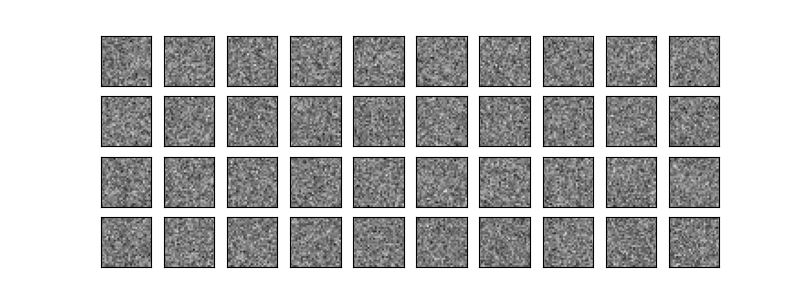

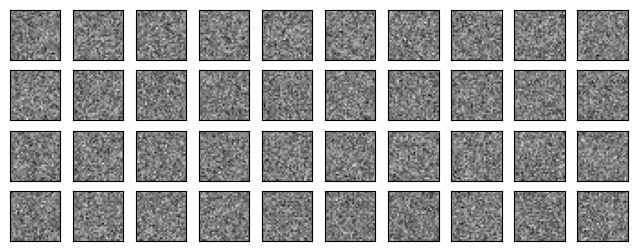

In [29]:
# create gif of images evolving over time, based on x_gen_store
from IPython.display import Image, display
fig, axs = plt.subplots(nrows=int(n_sample/n_classes), ncols=n_classes, sharex=True, sharey=True, figsize=(8,3))
def animate_diff(i, x_gen_store):
    print(f'gif animating frame {i} of {x_gen_store.shape[0]}', end='\r')
    plots = []
    for row in range(int(n_sample/n_classes)):
        for col in range(n_classes):
            axs[row, col].clear()
            axs[row, col].set_xticks([])
            axs[row, col].set_yticks([])
            plots.append(axs[row, col].imshow(x_gen_store[i,(row*n_classes)+col,0], cmap='gray', vmin=(x_gen_store[i]).min(), vmax=(x_gen_store[i]).max()))
    return plots
ani = FuncAnimation(fig, animate_diff, fargs=[x_gen_store], interval=200, blit=False, repeat=True, frames=x_gen_store.shape[0])
ani.save(save_dir + f"diffusion_sampling.gif", dpi=100, writer=PillowWriter(fps=5))
print('saved image at ' + save_dir + f"diffusion_sampling.gif")
display(Image(filename=save_dir+f"diffusion_sampling.gif"))


## 3. Conditional DDPM (10 pts)

In this question, you will complete a conditional version of the DDPM implementation (with classifier-free guidance) by filling in the following functions:

1. **`DDPM.forward(x, c)`**  
Implement the conditional DDPM training step. For a batch of clean images `x` and their class labels `c`, sample a random timestep, and return the DDPM traing loss. Randomly drop the class label so the model also learns an unconditional denoiser.

2. **`DDPM.sample(n_sample, size, device, guide_w)`**  
Implement the conditional DDPM sampling procedure with classifier-free guidance. Starting from pure Gaussian noise, iteratively denoise from \(T \rightarrow 1\) while conditioning on a target class label. At each step, combine the conditional and unconditional noise predictions using the guidance weight `guide_w` to steer generation toward the requested class. Return the final generated samples and the stored intermediate samples for visualization.


In [31]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7),
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t, context_mask):
        # x is (noisy) image, c is context label, t is timestep,
        # context_mask says which samples to block the context on

        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        # convert context to one hot embedding
        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)

        # mask out context if context_mask == 1
        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1, self.n_classes)
        context_mask = (1 - context_mask) # flip 0 <-> 1
        c = c * context_mask

        # embed context, time step
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1 * up1 + temb1, down2)
        up3 = self.up2(cemb2 * up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

In [37]:
class DDPM_C(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super(DDPM_C, self).__init__()
        self.nn_model = nn_model.to(device)

        # register_buffer allows accessing dictionary produced by ddpm_schedules
        # e.g. can access self.sqrtab later
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        """Calculate conditional DDPM training loss
        Input:
            x: torch.Tensor of shape (batch_size, 1, image_height, image_width)
            c: torch.Tensor of shape (batch_size,)
        Output:
            loss: torch.Tensor scalar, mean-squared error between true and predicted noise
        """
        _ts = torch.randint(1, self.n_T+1, (x.shape[0],)).to(self.device)
        noise = torch.randn_like(x)

        # dropout context with some probability
        context_mask = torch.bernoulli(torch.zeros_like(c) + self.drop_prob).to(self.device)
        # todo: student code here
        B = x.shape[0]
        # ---- forward diffusion q(x_t | x_0) ----
        sqrtab_t = self.sqrtab[_ts].view(B, 1, 1, 1)
        sqrtmab_t = self.sqrtmab[_ts].view(B, 1, 1, 1)
        x_t = sqrtab_t * x + sqrtmab_t * noise

        # normalize timestep to [0, 1] and give shape (B, 1)
        t_input = (_ts.float() / self.n_T).view(B, 1)

        pred_noise = self.nn_model(x_t, c, t_input, context_mask)

        # MSE loss between true noise and predicted noise
        loss = self.loss_mse(pred_noise, noise)
        return loss
        # end student code

    def sample(self, n_sample, size, device, guide_w = 0.0):
        """DDPM sampling, generate images by running the reverse diffusion process.
        Input:
            n_sample: int, number of samples to draw in parallel
            size: tuple, per-sample shape
            device: torch.device, device for tensors and models
            guide_w: float, guidance weight
        Output:
            x_i: torch.Tensor, final samples x_0 with shape (n_sample, *size)
            x_i_store: np.ndarray, trajectory snapshots collected during sampling
        """
        # we follow the guidance sampling scheme described in 'Classifier-Free Diffusion Guidance'
        # to make the fwd passes efficient, we concat two versions of the dataset,
        # one with context_mask=0 and the other context_mask=1
        # we then mix the outputs with the guidance scale, w
        # where w>0 means more guidance

        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1), sample initial noise
        c_i = torch.arange(0, 10).to(device)
        c_i = c_i.repeat(int(n_sample / c_i.shape[0]))

        # don't drop context at test time
        context_mask = torch.zeros_like(c_i).to(device)

        # double the batch
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1. # makes second half of batch context free

        x_i_store = []
        for i in range(self.n_T, 0, -1):
            # todo: student code here
            x_in = x_i.repeat(2, 1, 1, 1)

            # normalized timestep input, shape (2*n_sample, 1)
            t_input = torch.full(
                (2 * n_sample, 1),
                float(i) / self.n_T,
                device=device
            )
            eps = self.nn_model(x_in, c_i, t_input, context_mask)

            # split: first half conditional, second half unconditional
            eps_cond = eps[:n_sample]
            eps_uncond = eps[n_sample:]

            eps_guided = (1.0 + guide_w) * eps_cond - guide_w * eps_uncond

            # reverse diffusion step
            oneover_sqrta_t = self.oneover_sqrta[i]
            ma_over_sqrtmab_t = self.ma_over_sqrtmab[i]
            sqrt_beta_t = self.sqrt_beta_t[i]

            x_i = oneover_sqrta_t * (x_i - ma_over_sqrtmab_t * eps_guided)

            if i > 1:
                x_i = x_i + sqrt_beta_t * torch.randn_like(x_i)
            # end student code
            if i%20==0 or i==self.n_T or i<8:
                x_i_store.append(x_i.detach().cpu().numpy())

        x_i_store = np.array(x_i_store)
        return x_i, x_i_store

In [38]:
grader.check("q5")

q5 results: All test cases passed!

In [39]:
n_epoch = 10
batch_size = 256
n_T = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_classes = 10
n_feat = 128
lrate = 1e-4
os.makedirs('./ddpm_conditional/', exist_ok=True)
save_dir = './ddpm_conditional/'
ws_test = [0.0, 0.5, 2.0] # strength of generative guidance

ddpm = DDPM_C(nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=n_classes), betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
ddpm.to(device)

tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1

dataset = MNIST("./data", train=True, download=True, transform=tf)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=5)
optim = torch.optim.Adam(ddpm.parameters(), lr=lrate)

for ep in range(n_epoch):
    print(f'epoch {ep}')
    ddpm.train()

    # linear lrate decay
    optim.param_groups[0]['lr'] = lrate * (1 - ep / n_epoch)

    pbar = tqdm(dataloader)
    for x, c in pbar:
        optim.zero_grad()
        x = x.to(device)
        c = c.to(device)
        loss = ddpm(x, c)
        loss.backward()
        pbar.set_description(f"loss: {loss.item():.4f}")
        optim.step()

    ddpm.eval()
    with torch.no_grad():
        n_sample = 4 * n_classes
        for w_i, w in enumerate(ws_test):
            x_gen_c, x_gen_store = ddpm.sample(n_sample, (1, 28, 28), device, guide_w=w)
            grid = make_grid(x_gen_c, nrow=10)
            save_image(grid, save_dir + f"image_ep{ep}_w{w}.png")

epoch 0


loss: 0.0488: 100%|██████████| 235/235 [00:53<00:00,  4.43it/s]


epoch 1


loss: 0.0515: 100%|██████████| 235/235 [00:54<00:00,  4.34it/s]


epoch 2


loss: 0.0366: 100%|██████████| 235/235 [00:53<00:00,  4.36it/s]


epoch 3


loss: 0.0287: 100%|██████████| 235/235 [00:53<00:00,  4.37it/s]


epoch 4


loss: 0.0289: 100%|██████████| 235/235 [00:53<00:00,  4.37it/s]


epoch 5


loss: 0.0353: 100%|██████████| 235/235 [00:53<00:00,  4.36it/s]


epoch 6


loss: 0.0257: 100%|██████████| 235/235 [00:53<00:00,  4.36it/s]


epoch 7


loss: 0.0295: 100%|██████████| 235/235 [00:53<00:00,  4.36it/s]


epoch 8


loss: 0.0333: 100%|██████████| 235/235 [00:53<00:00,  4.36it/s]


epoch 9


loss: 0.0218: 100%|██████████| 235/235 [00:53<00:00,  4.36it/s]


In [40]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

HF_MODEL_ID = "farleyknight/mnist-digit-classification-2022-09-04"

proc = AutoImageProcessor.from_pretrained(HF_MODEL_ID)
clf  = AutoModelForImageClassification.from_pretrained(HF_MODEL_ID).to(device).eval()

@torch.no_grad()
def recognized_ratio(imgs, tau=0.9):
    imgs = imgs.clamp_(0, 1)
    B = imgs.size(0)
    imgs3 = imgs.repeat(1,3,1,1)
    inputs = proc(images=imgs3, do_rescale=False, return_tensors="pt").to(device)
    logits = clf(**inputs).logits
    probs  = logits.softmax(-1)
    return (probs.max(dim=1).values >= tau).float().mean().item()

print(f"Recognized samples: {recognized_ratio(x_gen_c, tau=0.9):.3f}")

Recognized samples: 1.000


The generated image quality will be manually graded by the TA. The grading guidelines include: the images should be recognizable as digits, they should cover different numbers from 0–9, and there should be no mode collapse within each class, and the categories should be correctly controlled by the provided class labels. You can refer to example generated samples here: https://drive.google.com/drive/folders/1EO_Gd_2bMaJDvlCMaX9vhSBzqOlj-nTn?usp=sharing.

The recognition ratio above is computed using a pretrained MNIST digit recognizer and it should be greater than 0.9 for conditional DDPM. Note that the final grading will be based on the manual grading according to the previously mentioned guidelines and the recognition ratio is only a reference metric.

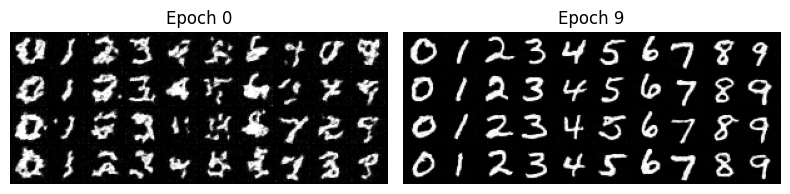

In [41]:
# visualize sampled images from the first epoch and the last epoch
import matplotlib.pyplot as plt
from PIL import Image

first, last = 0, n_epoch - 1
paths = [os.path.join("ddpm_conditional", f"image_ep{first}_w2.0.png"),
         os.path.join("ddpm_conditional", f"image_ep{last}_w2.0.png")]

fig, axes = plt.subplots(1, 2, figsize=(8, 8))
for ax, p, t in zip(axes, paths, [f"Epoch {first}", f"Epoch {last}"]):
    ax.imshow(Image.open(p), cmap='gray')
    ax.set_title(t)
    ax.axis('off')
plt.tight_layout()
plt.show()

saved image at ./ddpm_conditional/diffusion_sampling.gif


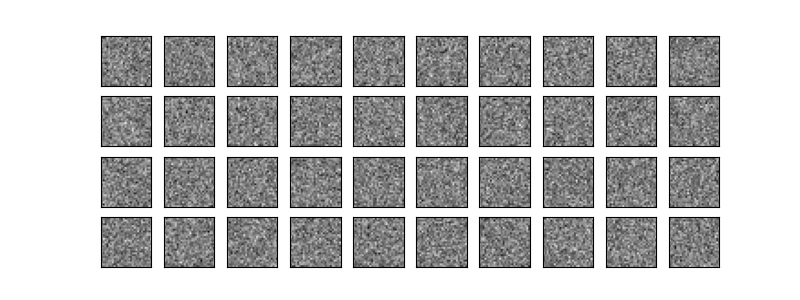

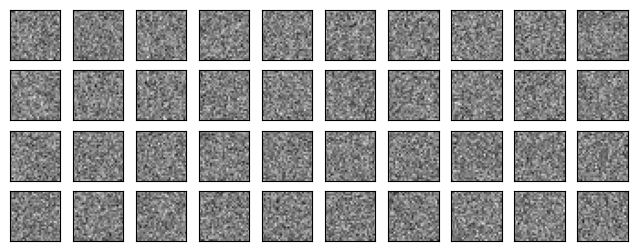

In [42]:
# create gif of images evolving over time, based on x_gen_store
from IPython.display import Image, display
fig, axs = plt.subplots(nrows=int(n_sample/n_classes), ncols=n_classes, sharex=True, sharey=True, figsize=(8,3))
def animate_diff(i, x_gen_store):
    print(f'gif animating frame {i} of {x_gen_store.shape[0]}', end='\r')
    plots = []
    for row in range(int(n_sample/n_classes)):
        for col in range(n_classes):
            axs[row, col].clear()
            axs[row, col].set_xticks([])
            axs[row, col].set_yticks([])
            plots.append(axs[row, col].imshow(x_gen_store[i,(row*n_classes)+col,0], cmap='gray', vmin=(x_gen_store[i]).min(), vmax=(x_gen_store[i]).max()))
    return plots
ani = FuncAnimation(fig, animate_diff, fargs=[x_gen_store], interval=200, blit=False, repeat=True, frames=x_gen_store.shape[0])
ani.save(save_dir + f"diffusion_sampling.gif", dpi=100, writer=PillowWriter(fps=5))
print('saved image at ' + save_dir + f"diffusion_sampling.gif")
display(Image(filename=save_dir+f"diffusion_sampling.gif"))

## 3. Questions (4 pts)

1. Compare the generated image quality of VAE and DDPM, then analyze the reasons for the difference.

2. Propose a method to accelerate sampling in diffusion models (no implementation required). Briefly describe the core idea, and explain how it reduces denoising steps or compute.